# 0.0. Imports

In [78]:
import pandas as pd
import numpy as np
from scipy import stats as ss

import inflection

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from boruta import  BorutaPy

import datetime

import warnings
warnings.filterwarnings('ignore')

### 0.1. Helper Functions

In [75]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    return np.sqrt((chi2corr / n) / ( min(kcorr - 1, rcorr - 1 )))
    

    def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])


IndentationError: expected an indented block (532579260.py, line 13)

### 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
61009,800,7,2015-06-07,0,0,0,0,0,0,d,a,2020.0,7.0,2014.0,0,NaN,NaN,NaN


# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [7]:
old_cols= df1.columns
snakecase = lambda x: inflection.underscore( x )
new_cols = list ( map( snakecase, old_cols))
# rename
df1.columns = new_cols

### 1.2. Data Dimensions

In [8]:
print('Number of rows: ', df1.shape[0])
print('Number of columns: ', df1.shape[1])

Number of rows:  1017209
Number of columns:  18


### 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

In [11]:
# competition_distance
print("Max distance: ", df1['competition_distance'].max())
df1['competition_distance'] = df1['competition_distance'].fillna(200000)
print("Max distance: ", df1['competition_distance'].max())

Max distance:  75860.0
Max distance:  200000.0


In [12]:
# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) == True else x['competition_open_since_month'], axis = 1)

In [13]:
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) == True else x['competition_open_since_year'], axis = 1)

In [14]:
# promo2_since_week
print("Distribution of promo 2: \n", df1['promo2'].value_counts())
print("Nan values in promo_2_since_week: ", len(df1['promo2_since_week'][df1['promo2_since_week'].isna() == True]))
print("Stores that didn't have promo 2 and has 'Nan' values in 'promo_2_since_week': ", len(df1[['promo2','promo2_since_week']][(df1['promo2_since_week'].isna() == True) & (df1['promo2'] == 0)]))
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) == True else x['promo2_since_week'], axis = 1)

Distribution of promo 2: 
 1    509178
0    508031
Name: promo2, dtype: int64
Nan values in promo_2_since_week:  508031
Stores that didn't have promo 2 and has 'Nan' values in 'promo_2_since_week':  508031


In [15]:
# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) == True else x['promo2_since_year'], axis = 1)

In [16]:
# promo_interval
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.apply(lambda x: months[x])
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [17]:
df1.sample(8).T

,436292,321656,747027,110217,567711,524528,56555,810151
store,1113,236,763,948,962,149,806,332
day_of_week,5,3,6,5,6,2,4,5
date,2014-06-06 00:00:00,2014-10-01 00:00:00,2013-08-31 00:00:00,2015-04-24 00:00:00,2014-02-08 00:00:00,2014-03-18 00:00:00,2015-06-11 00:00:00,2013-07-05 00:00:00
sales,7705,9507,5939,8100,5766,6176,4842,4654
customers,794,1078,608,2210,766,548,417,564
open,1,1,1,1,1,1,1,1
promo,1,1,0,0,0,1,0,1
state_holiday,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0
store_type,a,a,d,b,c,d,d,a


In [18]:
pd.DataFrame([df1.isna().sum(), df1.dtypes]).T

,0,1
store,0,int64
day_of_week,0,int64
date,0,datetime64[ns]
sales,0,int64
customers,0,int64
open,0,int64
promo,0,int64
state_holiday,0,object
school_holiday,0,int64
store_type,0,object


### 1.6. Change Types

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Descriptive Statistics

In [20]:
df2 = df1.copy()
num_attributes = df2.select_dtypes(include = ['int32','int64','float64'])
cat_attributes = df2.select_dtypes(exclude = ['int32','int64','float64','datetime64[ns]'])

In [21]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion : std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
stats = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6]).T.reset_index()
stats.columns = ['attributes','mean','median','std','min','max','range','skew','kurtosis']
stats

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

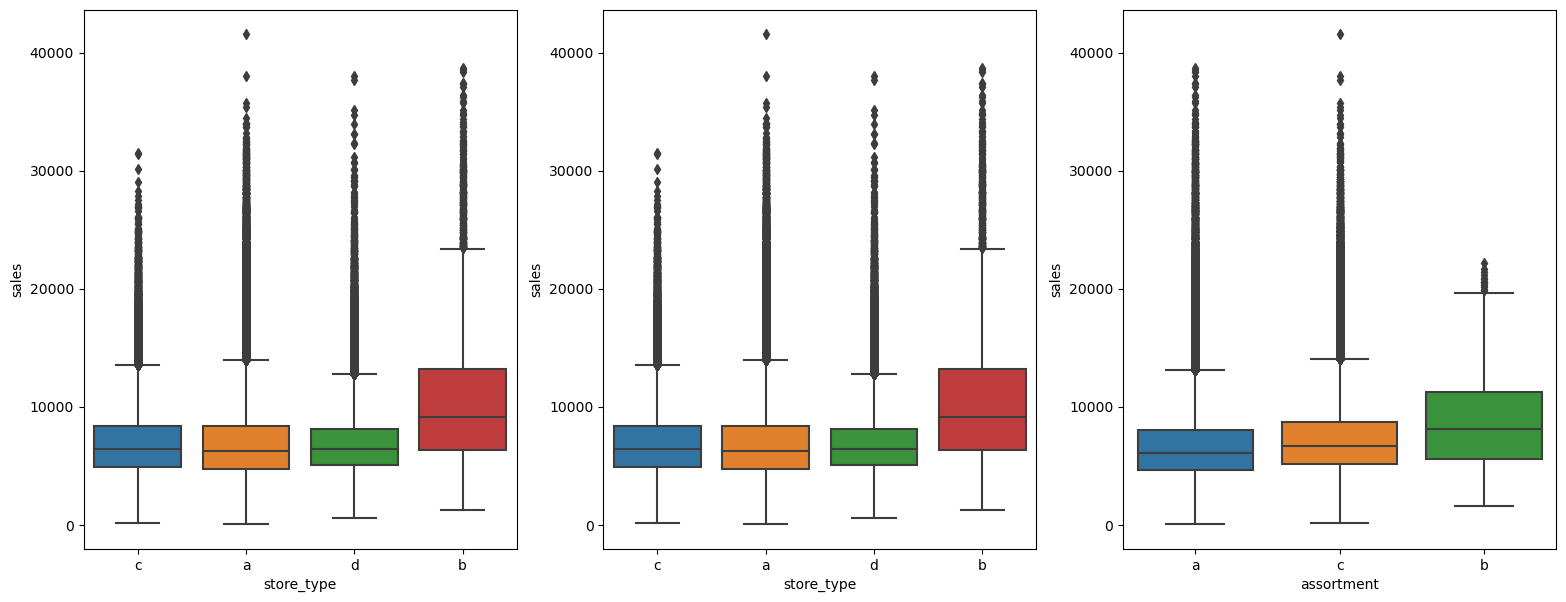

In [23]:
# Tamanho
Figura, Eixo = plt.subplots(figsize=(19, 7))

plt.subplot(1, 3 ,1)
sns.boxplot(x = 'store_type',y = 'sales', data = df2[(df2['sales'] != 0) & (df2['store_type'] != '0')])
plt.subplot (1, 3, 2)
sns.boxplot(x = 'store_type',y = 'sales', data = df2[df2['sales'] != 0])
plt.subplot (1, 3, 3)
sns.boxplot(x = 'assortment',y = 'sales', data = df2[df2['sales'] != 0])

# 2.0. Feature Engineering

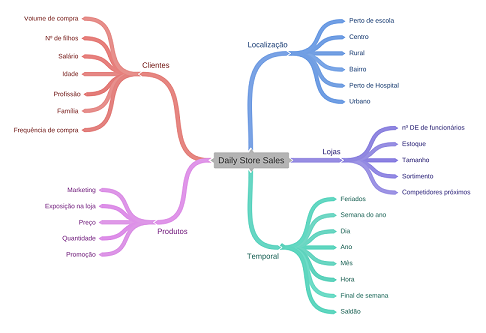

In [24]:
df3 = df2.copy()
Image('Img\mind_map_hypotesis.png', width = 800, height = 500)

### 2.1. Criação das Hipóteses

#### 2.2.1. Hipóteses Loja

- Lojas com maior quadro de funcionários deveriam vender mais

- Lojas com maior estoque deveriam vender mais

- Lojas de maior porte deveriam vender mais

- Lojas de menor porte deveriam vender menos

- Lojas com maior sortimento deveriam vender mais

- Lojas com competidores mais próximos deveriam vender menos

- Lojas com competidores mais distantes deveriam vender mais

#### 2.2.2. Hipóteses produto

- Lojas que investem mais em marketing deveriam vender mais

- Lojas que expõem mais os produtos na vitrine deveriam vender mais

- Lojas que tem preços menores deveriam vender mais

- Lojas que tem preços menores por mais tempo deveriam vender mais

- Lojas com promoções ativas por mais tempo deveriam vender mais

- Lojas com mais dias de promoção deveriam vender mais

- Lojas com promoções consecutivas deveriam vender mais

#### 2.2.3. Hipóteses Tempo

- Lojas abertas dirante o Natala deveriam vender mais

- Lojas deveriam vender mais ao longo dos anos

- Lojas deveriam vender mais no segundo semertre do ano

- Lojas deveriam vender mais depois do dia 10 de cada mês

- Lojas deveriam vender menos aos finais de semana

- Lojas deveriam vender menos durante feriados escolares

### 2.2. Lista de hipóteses finais

- Lojas com maior sortimento deveriam vender mais

- Lojas com competidores mais próximos deveriam vender menos

- Lojas com competidores à mais tempo deveriam vender mais

- Lojas com promoções ativas por mais tempo deveriam vender mais

- Lojas com mais dias de promoção deveriam vender mais

- Lojas com promoções consecutivas deveriam vender mais

- Lojas abertas durante o Natal deveriam vender mais

- Lojas deveriam vender mais ao longo dos anos

- Lojas deveriam vender mais no segundo semestre do ano

- Lojas deveriam vender mais depois do dia 10 de cada mês

- Lojas deveriam vender menos aos finais de semana

- Lojas deveriam vender menos durante feriados escolares

### 2.3. Feature Engineering

In [25]:
df3 = df2.copy()
# year
df3['year'] = df3['date'].dt.year
# month
df3['month'] = df3['date'].dt.month
# day
df3['day'] = df3['date'].dt.day
# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear
# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df3['competition_time_month'] = ((df3['date'] - df3['competition_since']) / 30).apply(lambda x: x.days).astype(int)
# promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df3['promo_time_week'] = ((df3['date'] - df3['promo_since']) / 7).apply(lambda x: x.days).astype(int)
# assortment
dict_assort = {'a': 'basic', 'b': 'extra','c': 'extended'}
df3['assortment'] = df3['assortment'].apply(lambda x: dict_assort[x])
# state holiday
dict_holiday = {'0': 'regular_day', 'a':'public_holiday','b': 'easter','c': 'christmas'}
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: dict_holiday[x])

In [26]:
df3.sample(5).T

,923844,319146,312872,772328,242201
store,295,581,910,419,257
day_of_week,1,6,6,4,4
date,2013-03-25 00:00:00,2014-10-04 00:00:00,2014-10-11 00:00:00,2013-08-08 00:00:00,2014-12-25 00:00:00
sales,7332,3111,4519,4085,0
customers,785,357,488,790,0
open,1,1,1,1,0
promo,1,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,christmas
school_holiday,1,0,0,0,1
store_type,a,a,d,c,a


# 3.0. Variable Filtering

In [27]:
df4 = df3.copy()

### 3.1. Filtragem das linhas

In [28]:
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

### 3.2 Seleção das colunas

In [29]:
cols_drop = ["customers","open","promo_interval","month_map"]
df4 =df4.drop(cols_drop, axis = 1)

# 4.0. Exploratory Data Analysis

In [30]:
df5 = df4.copy()

### 4.1. Análise Univariada

#### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales'>

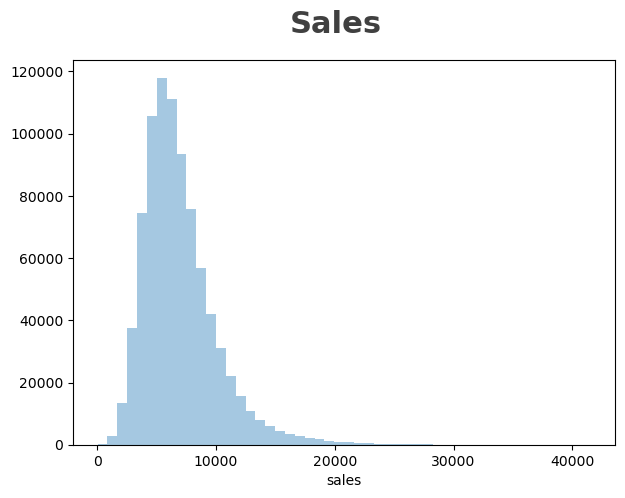

In [31]:
Figura, Eixo = plt.subplots(figsize=(7, 5))
plt.suptitle('Sales', fontsize=22, color='#404040', fontweight=600)
sns.distplot(df4['sales'], kde = False)

#### 4.1.2. Numerical Variables

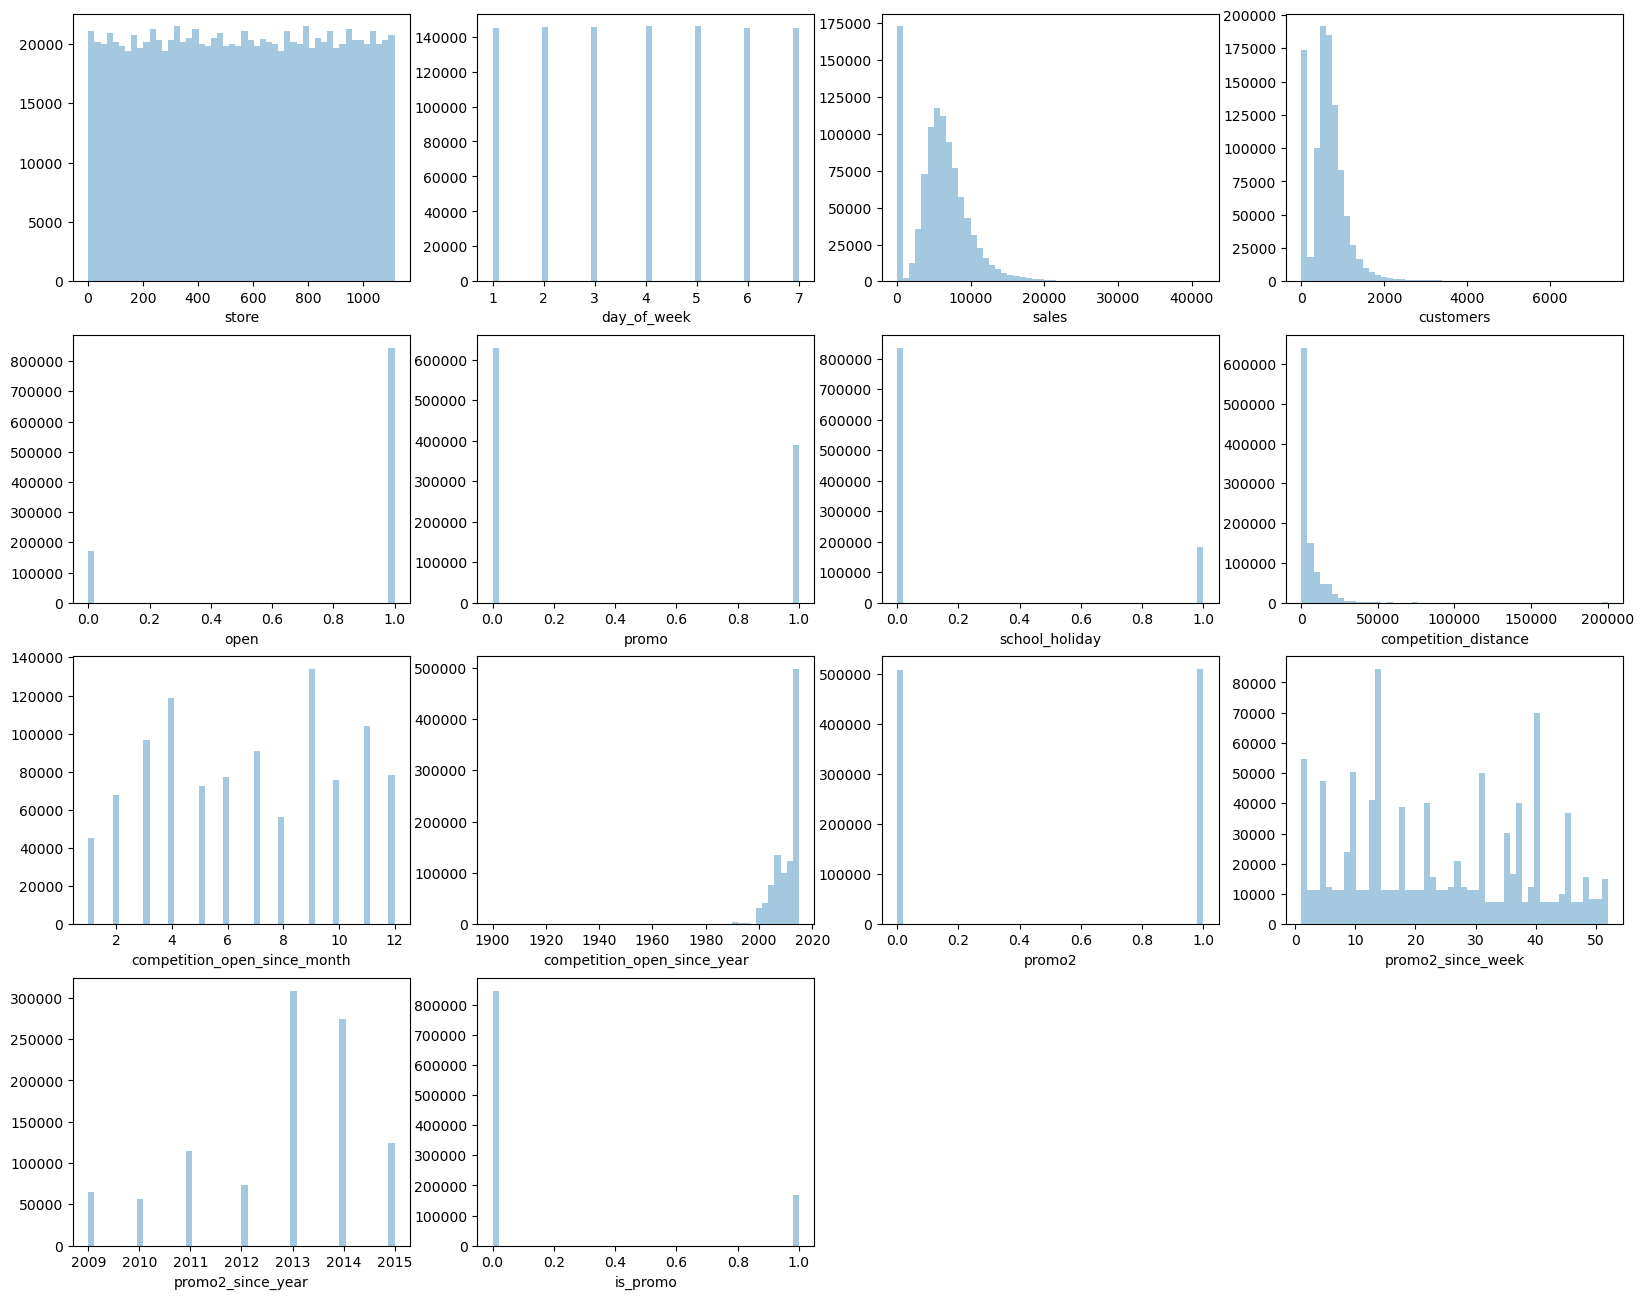

In [32]:
plt.rcParams["figure.figsize"] = (20,16)
for i in range(len(num_attributes.columns)):
    cols = num_attributes.columns
    plt.subplot(4, 4, i+1)
    sns.distplot(num_attributes[cols[i]], kde = False)

#### 4.1.3.Categorical Variables

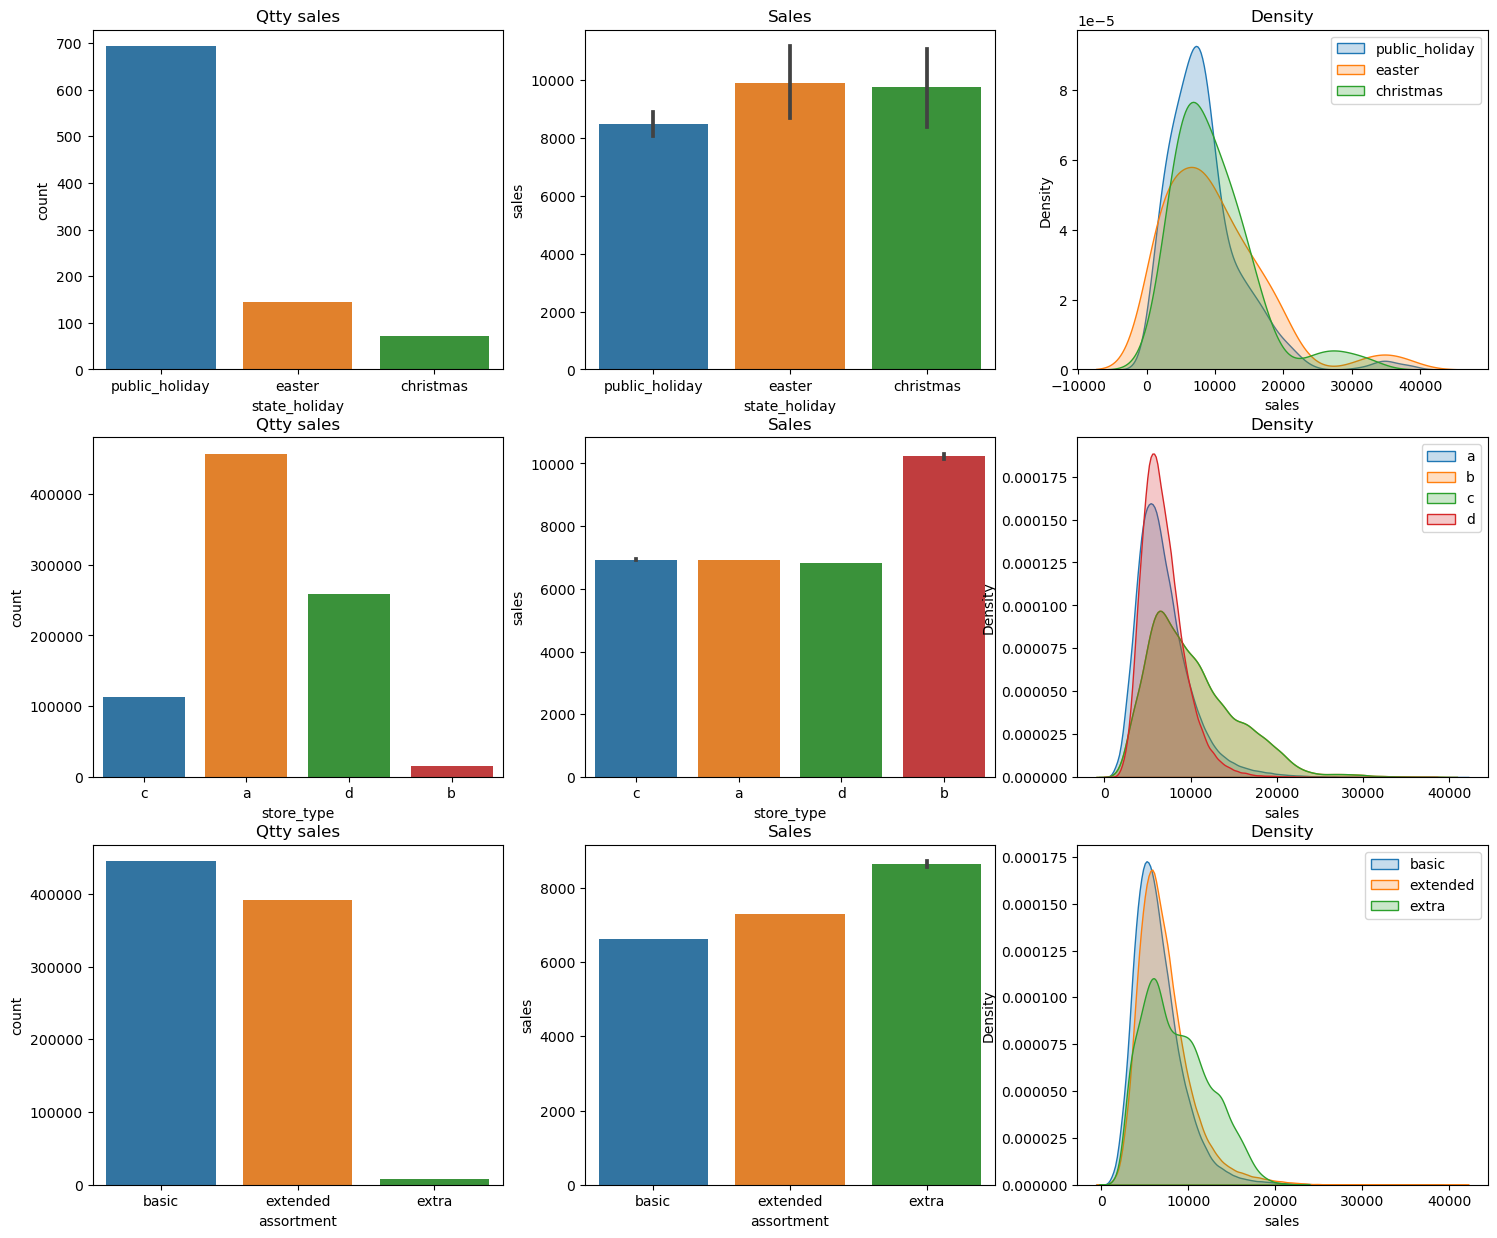

In [33]:
plt.rcParams["figure.figsize"] = (18,15)
plt.subplot(3, 3, 1)
plt.title('Qtty sales')
sns.countplot(x = df5['state_holiday'][df5['state_holiday'] != 'regular_day'] )
plt.subplot(3, 3, 2)
plt.title('Sales')
sns.barplot(x = df5['state_holiday'][df5['state_holiday'] != 'regular_day'] , y = df5['sales'])
plt.subplot(3, 3, 3)
plt.title('Density')
sns.kdeplot(x = df5['sales'][df5['state_holiday'] == 'public_holiday'] , label = 'public_holiday', shade = True)
sns.kdeplot(x = df5['sales'][df5['state_holiday'] == 'easter'] , label = 'easter', shade = True)
sns.kdeplot(x = df5['sales'][df5['state_holiday'] == 'christmas'] , label = 'christmas', shade = True)
plt.legend(labels = ['public_holiday','easter','christmas'],loc = 'upper right')


plt.subplot(3, 3, 4)
plt.title('Qtty sales')
sns.countplot(x = df5['store_type'] )
plt.subplot(3, 3, 5)
plt.title('Sales')
sns.barplot(x = df5['store_type'] , y = df5['sales'])
plt.subplot(3, 3, 6)
plt.title('Density')
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'a'] , label = 'a', shade = True)
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'b'] , label = 'b', shade = True)
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'b'] , label = 'c', shade = True)
sns.kdeplot(x = df5['sales'][df5['store_type'] == 'd'] , label = 'd', shade = True)
plt.legend(labels = ['a','b','c','d'],loc = 'upper right')

plt.subplot(3, 3, 7)
plt.title('Qtty sales')
sns.countplot(x = df5['assortment'] )
plt.subplot(3, 3, 8)
plt.title('Sales')
sns.barplot(x = df5['assortment'] , y = df5['sales'])
plt.subplot(3, 3, 9)
plt.title('Density')
sns.kdeplot(x = df5['sales'][df5['assortment'] == 'basic'] , label = 'basic', shade = True)
sns.kdeplot(x = df5['sales'][df5['assortment'] == 'extended'] , label = 'extended', shade = True)
sns.kdeplot(x = df5['sales'][df5['assortment'] == 'extra'] , label = 'extra', shade = True)
plt.legend(labels = ['basic','extended','extra'],loc = 'upper right')



### 4.2. Análise Bivariada

- **Hipótese 1:** Lojas com maior sortimento deveriam vender mais\
**VERDADEIRA** : Lojas com maior sortimento (extended e extra) tem um faturamento médio maior

<AxesSubplot:title={'center':'Sales by assortment'}, xlabel='year_week'>

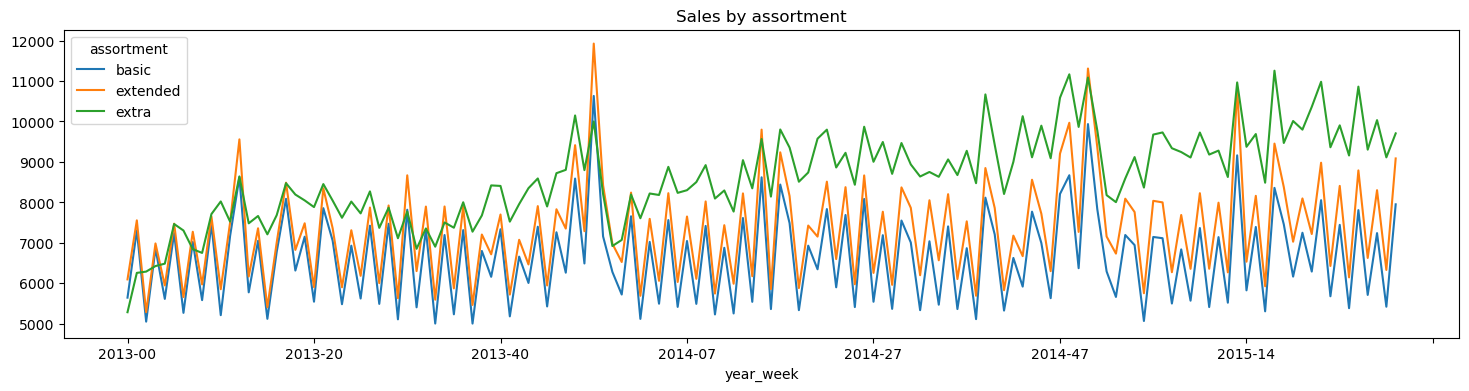

In [34]:
assort_sales = df5[['assortment','sales','date']].groupby('assortment').agg({'sales':'sum', 'date': 'count'}).reset_index().rename(columns={'date':'count'})
plt.rcParams["figure.figsize"] = (18,4)

assort_sales_2 = df5[['year_week','assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
assort_sales_2 = assort_sales_2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
assort_sales_2.plot(title = 'Sales by assortment')

In [35]:
assort_sales['avg_sales'] = assort_sales['sales']/assort_sales['count']
assort_sales

,assortment,sales,count,avg_sales
0,basic,2945750070,444875,6621.523057
1,extended,2856484241,391254,7300.843547
2,extra,70946312,8209,8642.503594


-  **Hipótese 2:**  Lojas com competidores mais próximos deveriam vender menos\
**FALSA** : As vendas não são impactadas pela distância do competidor

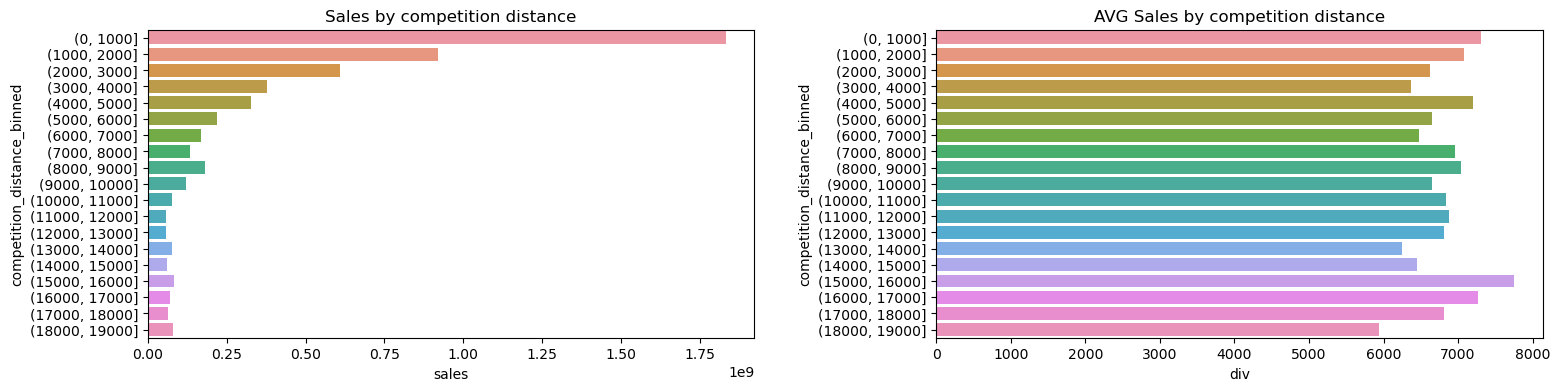

In [36]:
plt.rcParams["figure.figsize"] = (18,4)
plt.subplot(1, 2, 1)
comp_dist = df5[['store','competition_distance','sales']]
bins = list(np.arange(0,20000, 1000))
comp_dist['competition_distance_binned'] = pd.cut(comp_dist['competition_distance'], bins = bins)
comp_dist_2 = comp_dist.groupby('competition_distance_binned').sum().reset_index()

plt.title ('Sales by competition distance')
sns.barplot(y = 'competition_distance_binned', x = 'sales', data = comp_dist_2)
plt.subplot(1, 2, 2)
comp_dist_3 = comp_dist.groupby('competition_distance_binned').agg({'competition_distance':'count', 'sales': 'sum'}).reset_index()
comp_dist_3['div'] = comp_dist_3['sales'] / comp_dist_3['competition_distance']
plt.title ('AVG Sales by competition distance')
sns.barplot(y = 'competition_distance_binned', x = 'div', data = comp_dist_3)
plt.subplots_adjust(wspace=0.3)

<AxesSubplot:title={'center':'Competition distance vs Sales - scatterplot'}, xlabel='competition_distance', ylabel='sales'>

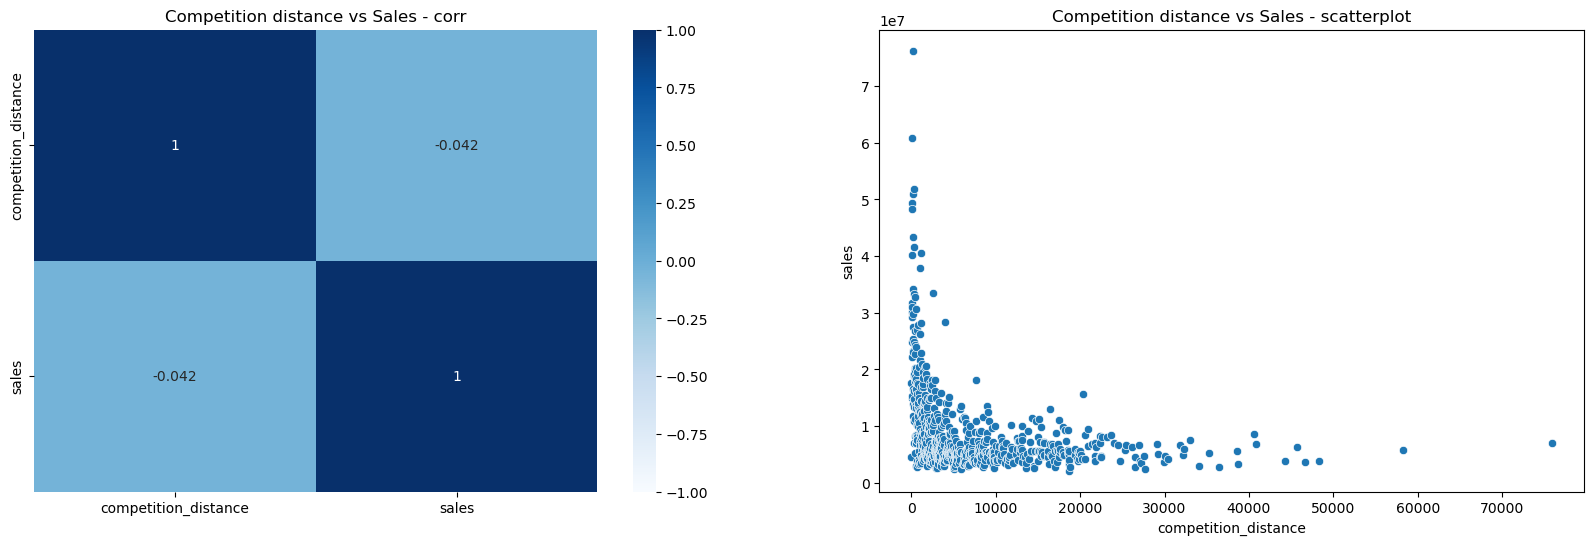

In [37]:
plt.rcParams["figure.figsize"] = (20,6)
plt.subplot(1, 2, 1)
plt.title ('Competition distance vs Sales - corr')
sns.heatmap(comp_dist[['competition_distance','sales']].corr(method = 'pearson'), annot = True, cmap = 'Blues', vmin = -1, vmax = 1)
plt.subplot(1, 2, 2)
comp_dist = comp_dist.groupby('competition_distance').sum().reset_index()
plt.title ('Competition distance vs Sales - scatterplot')
sns.scatterplot(x = comp_dist['competition_distance'][comp_dist['competition_distance']<200000], y = comp_dist['sales'], data = comp_dist)


- **Hipótese 3:**  Lojas com competidores à mais tempo deveriam vender mais \
**FALSA** : Quanto maior o tempo de competição, menor o faturamento

<AxesSubplot:title={'center':'Sales x Competition time (month)'}, xlabel='competition_time_month', ylabel='sales'>

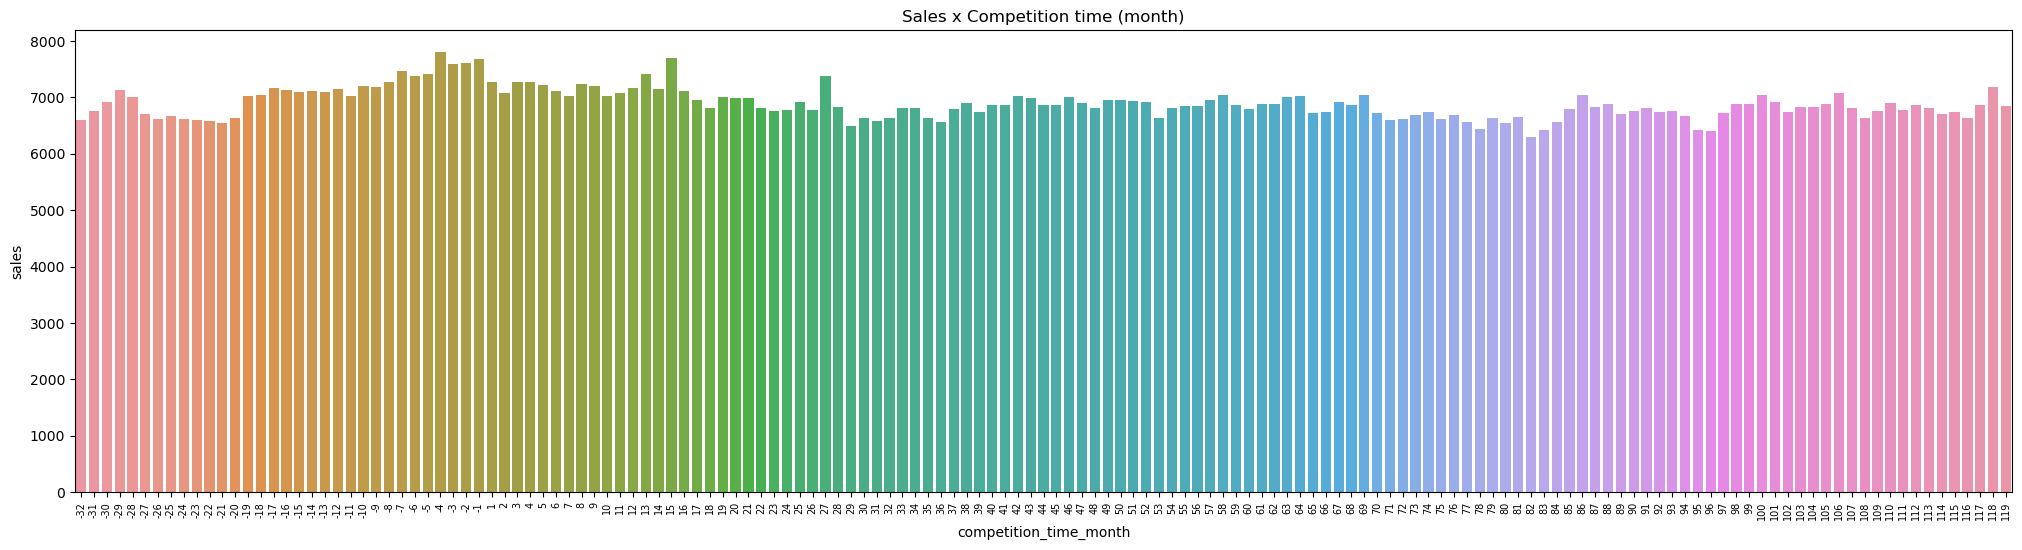

In [38]:
plt.rcParams["figure.figsize"] = (25,6)
plt.title("Sales x Competition time (month)")
competition_since = df5[['competition_time_month','sales','year']]
competition_since = competition_since[competition_since['year'] != 2015]
competition_since = competition_since[(competition_since['competition_time_month'] < 120) & (competition_since['competition_time_month'] != 0)]
competition_since = competition_since.groupby('competition_time_month').mean().reset_index()
plt.xticks(fontsize = 7, rotation = 90)
sns.barplot(x = 'competition_time_month', y = 'sales', data = competition_since)

<AxesSubplot:title={'center':'Correlation'}>

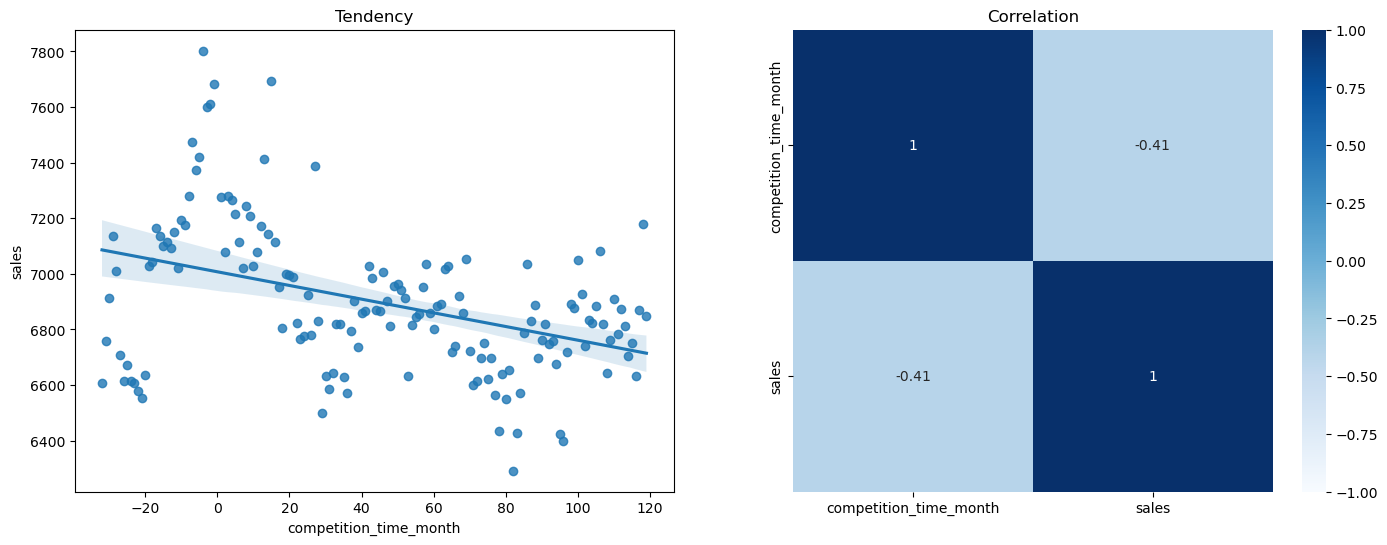

In [39]:
plt.rcParams["figure.figsize"] = (17,6)
plt.subplot(1, 2, 1)
plt.title("Tendency")
sns.regplot(x = 'competition_time_month', y = 'sales', data = competition_since)

plt.subplot(1, 2, 2)
plt.title("Correlation")
sns.heatmap(competition_since[['competition_time_month','sales']].corr(method = 'pearson'), annot = True,cmap = 'Blues', vmin = -1, vmax = 1 )


-  **Hipótese 4:** Lojas com mais dias de promoção deveriam vender mais\
**FALSA** : As variações foram identificadas devido a aletoriedade dos dados, portanto não é possível confirmar esta afirmação

<AxesSubplot:title={'center':'Tendency'}, xlabel='percentage', ylabel='sales'>

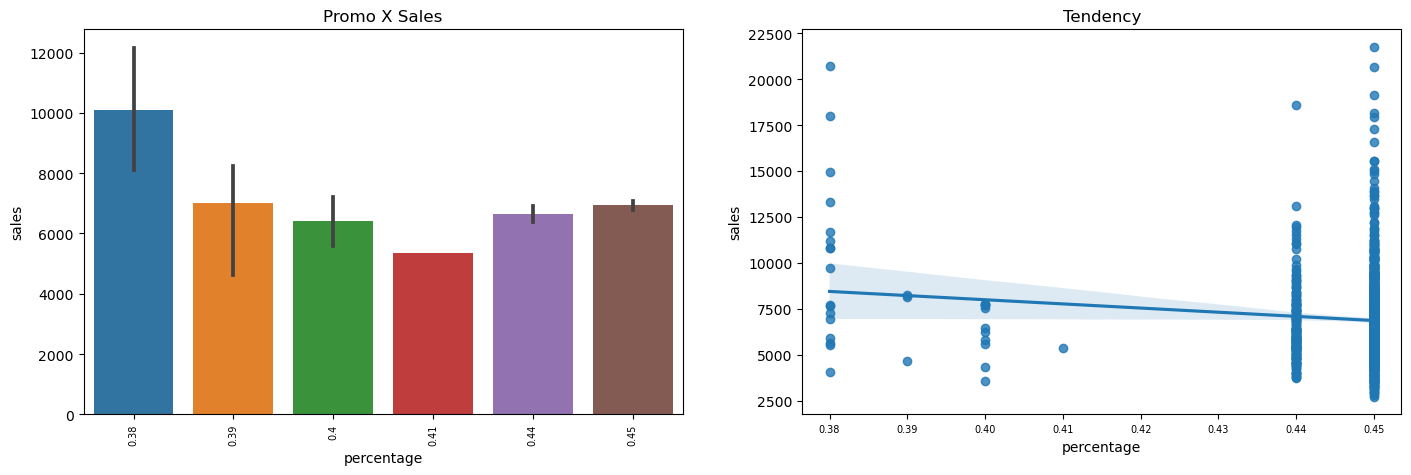

In [40]:
plt.rcParams["figure.figsize"] = (17,5)
plt.subplot(1, 2, 1)
plt.xticks(fontsize=7,rotation = 90)
plt.title("Promo X Sales")
promo = df5[['store','promo','sales','date']].groupby('store').agg({'sales':'mean', 'date': 'count','promo':'sum'}).reset_index().rename(columns={'date':'days','promo':'days_of_promo'})
promo['percentage'] = (promo['days_of_promo'] / promo['days']).round(2)

sns.barplot(x = 'percentage', y = 'sales', data = promo)

plt.subplot(1, 2, 2)
plt.title("Tendency")
plt.xticks(fontsize=7)
sns.regplot(x = 'percentage', y = 'sales', data = promo)

- **Hipótese 5:** Lojas com promoções ativas por mais tempo deveriam vender mais\
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

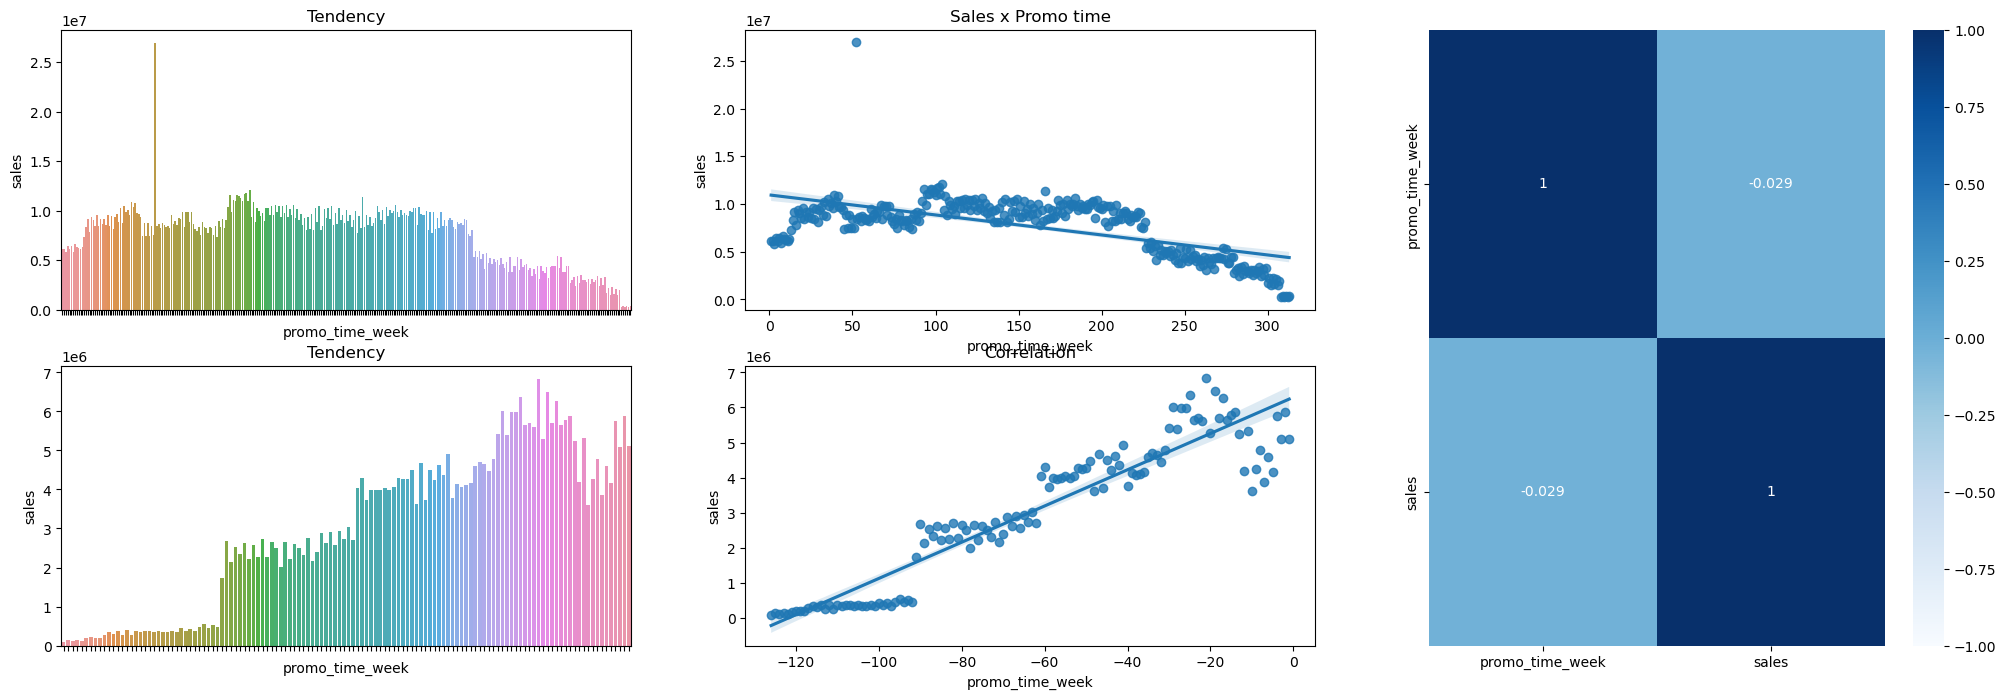

In [41]:
plt.rcParams["figure.figsize"] = (25,8)
time_promo = df5[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = matplotlib.gridspec.GridSpec( 2, 3 )
plt.title("Sales x Promo time")
plt.subplot( grid[0,0] )
time_promo_2 = time_promo[time_promo['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=time_promo_2 ).set(xticklabels=[]);

plt.title("Tendency")
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=time_promo_2 );

plt.title("Sales x Promo time")
plt.subplot( grid[1,0] )
time_promo_3 = time_promo[time_promo['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=time_promo_3 ).set(xticklabels=[]);

plt.title("Tendency")
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=time_promo_3 );

plt.title("Correlation")
plt.subplot( grid[:,2] )
sns.heatmap( time_promo.corr( method='pearson' ), annot=True, cmap = 'Blues', vmin = -1, vmax = 1 );

-  **Hipótese 6:** Lojas com promoções consecutivas deveriam vender mais\
**FALSA** Lojas com promocoes consecutivas vendem menos

In [42]:
df5[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


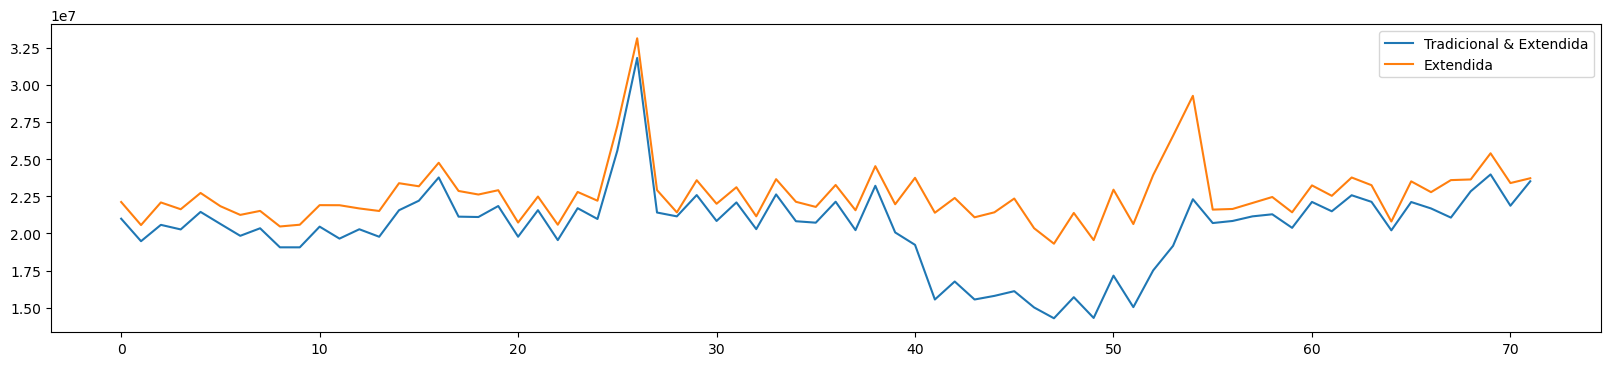

In [43]:
plt.rcParams["figure.figsize"] = (20,4)

promos = df5[( df5['promo'] == 1 ) & ( df5['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = promos.plot()

promos_1 = df5[( df5['promo'] == 1 ) & ( df5['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
promos_1.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

  **Hipótese 7:** Lojas abertas durante o Natal deveriam vender mais\
**VERDADEIRA** Lojas que abriram nos dias 25 e 26/12 nos anos de 2013 e 214 possuem um faturamento maior do que as lojas que só abriram no dia 26/12, seguido pelas lojas que não abriram nos feriados de natal.
  

<AxesSubplot:title={'center':'Sales x holiday'}, xlabel='year', ylabel='avg_sales'>

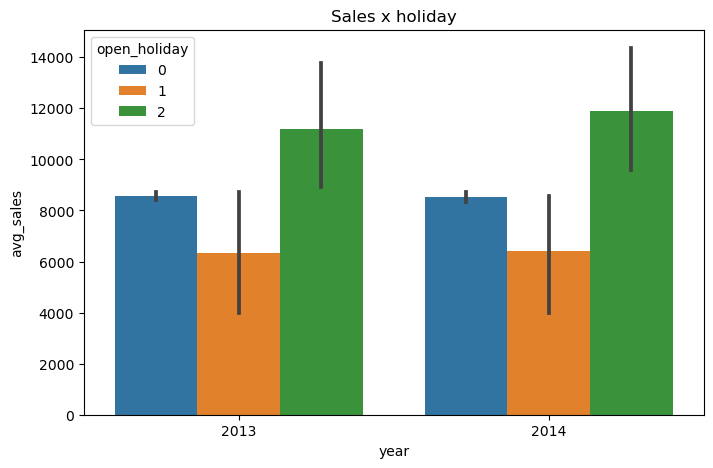

In [44]:
plt.rcParams["figure.figsize"] = (8,5)
plt.title('Sales x holiday')
stores_christmas = df5[['store','date','state_holiday','year','month','sales']][df5['month'] == 12]
stores_christmas['state_holiday'] = stores_christmas['state_holiday'].apply(lambda x: 1 if x=='christmas' else 0)
stores_christmas_grouped = stores_christmas.groupby(['store','year']).agg(    open_holiday = ('state_holiday', 'sum'), month = ('month','mean'), avg_sales = ('sales','mean') ).reset_index()
sns.barplot(x = 'year', y = 'avg_sales', hue = 'open_holiday', data = stores_christmas_grouped )

**Hipótese 8:**  Lojas deveriam vender mais ao longo dos anos\
**VERDADEIRA** Existe uma tendência de aumento de vendas ao longo dos anos

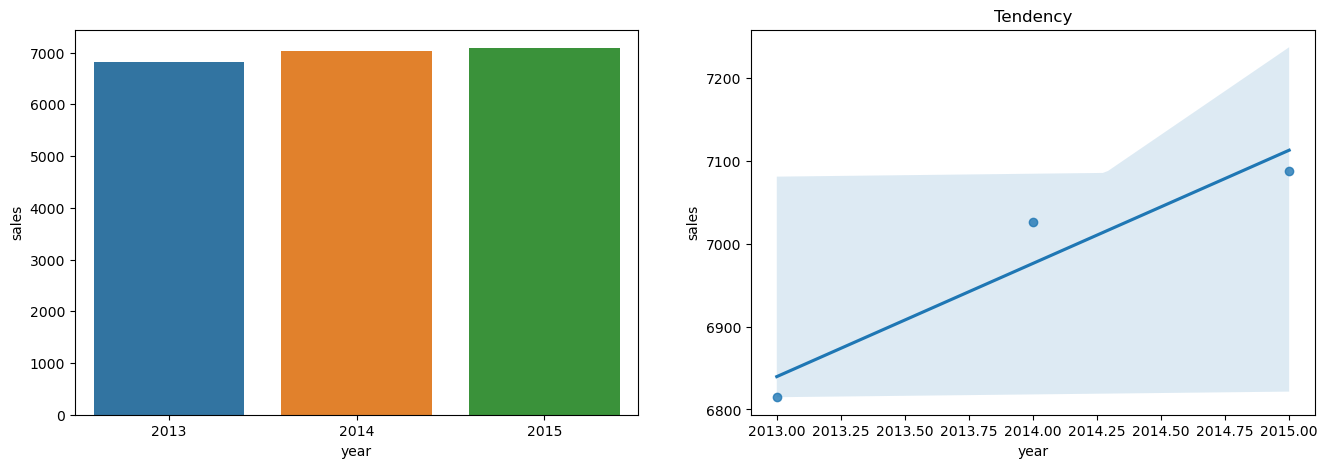

In [45]:
plt.rcParams["figure.figsize"] = (16,5)
plt.title('Sales x year')
time_years = df5[['year', 'sales']].groupby( 'year' ).mean().reset_index()
plt.subplot( 1, 2, 1 )
sns.barplot( x='year', y='sales', data=time_years );
plt.subplot( 1, 2, 2 )
plt.title('Tendency')
sns.regplot( x='year', y='sales', data=time_years );

**Hipótese 9:**  Lojas deveriam vender mais no segundo semestre do ano\
**VERDADEIRA** Existe um pequeno aumento de vendas no segundo semestre. Analisando o gráfico mensal, podemos notar que isso ocorre devido as vendas do mês de dezembro

<AxesSubplot:title={'center':'Sales x month'}, xlabel='month', ylabel='sales'>

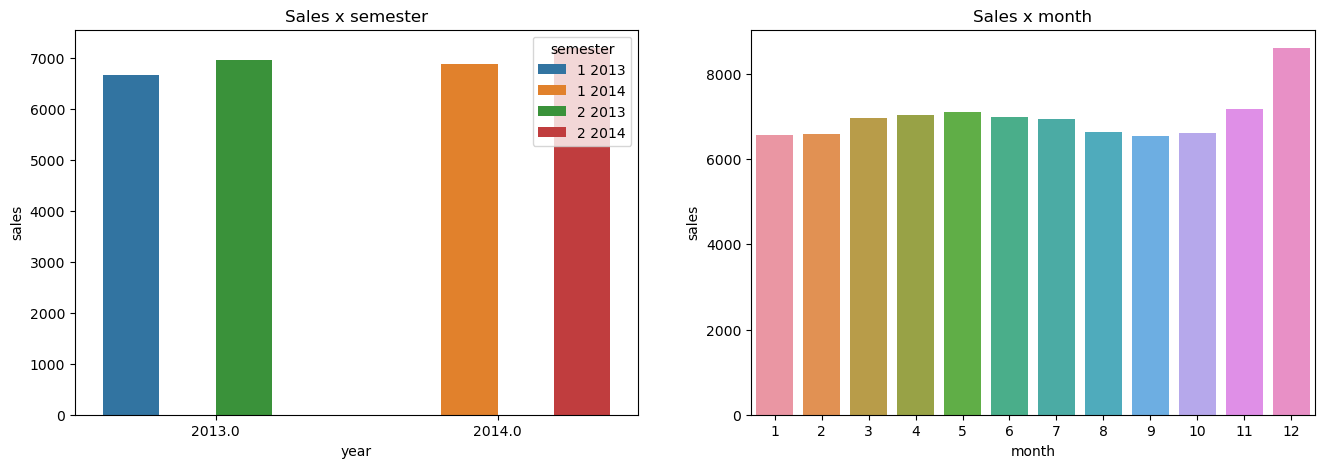

In [46]:
plt.rcParams["figure.figsize"] = (16,5)
plt.subplot( 1, 2, 1 )
plt.title('Sales x semester')
year_sales = df5[['year','month','sales']]
year_sales['semester'] = year_sales['month'].apply(lambda x: 1 if x <= 6 else 2)
year_sales['semester'] = year_sales.apply(lambda x: str(x['semester']) + " " + str(x['year']), axis = 1)
year_sales = year_sales.groupby('semester').mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'semester', data = year_sales[year_sales['year'] != 2015] )

plt.subplot( 1, 2, 2 )
plt.title('Sales x month')
year_sales = df5[['year','month','sales']]
year_sales = year_sales.groupby('month').mean().reset_index()
sns.barplot(x = 'month', y = 'sales', data = year_sales[year_sales['year'] != 2015] )

**Hipótese 10:**  Lojas deveriam vender mais depois do dia 10 de cada mês\
**VERDADEIRA** As vendas aumentam a partir do dia 11 de cada mês, porem voltam a dimunuir a partir do dia 19-20

<AxesSubplot:title={'center':'Sales x days'}, xlabel='day', ylabel='sales'>

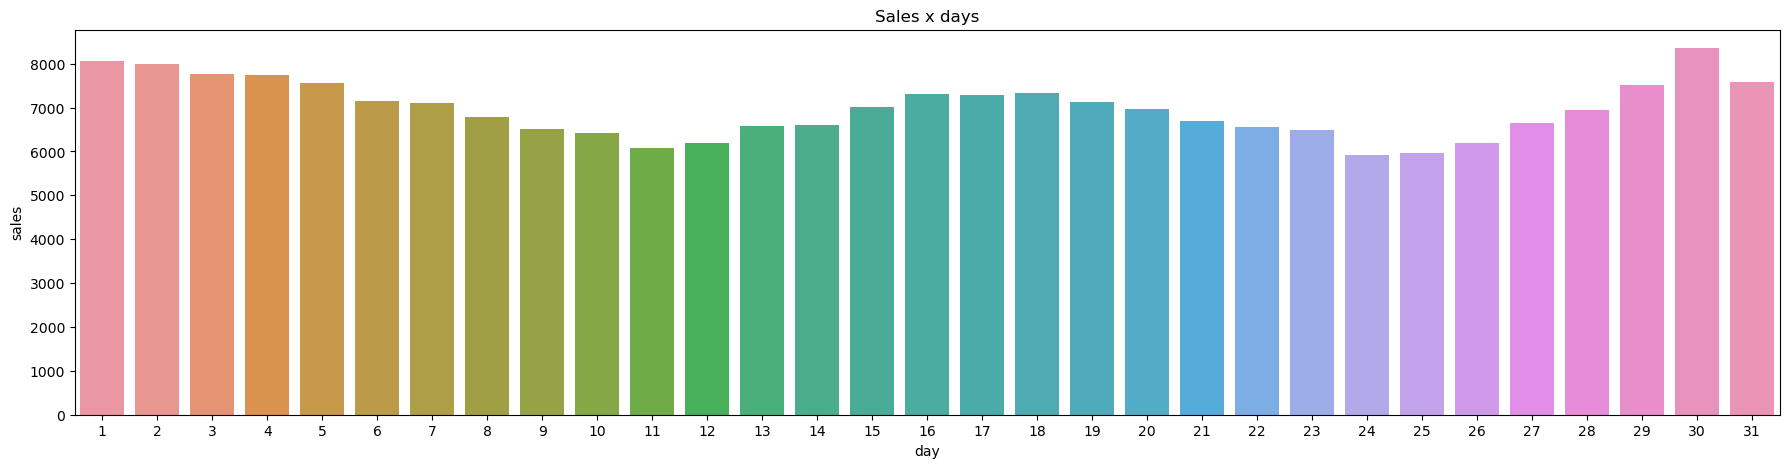

In [47]:
plt.rcParams["figure.figsize"] = (22,5)
plt.title('Sales x days')
daily_sales = df5[['day', 'sales']].groupby('day').mean().reset_index()
sns.barplot(x = 'day', y = 'sales', data = daily_sales)

**Hipótese 11:**  Lojas deveriam vender menos aos finais de semana\
**VERDADEIRA** As vendas totais são menores nos sábados e bem menores nos domingos (pois muitas lojas não abrem nos domingos). Considerando a média, as vendas no domingo são alta, isso pode ocorrer pelo fato de as lojas abrirem no domingo somente para uma ocasião especial (feriado, promoção, etc)

<AxesSubplot:title={'center':'total sales x week days'}, xlabel='week_day', ylabel='sales'>

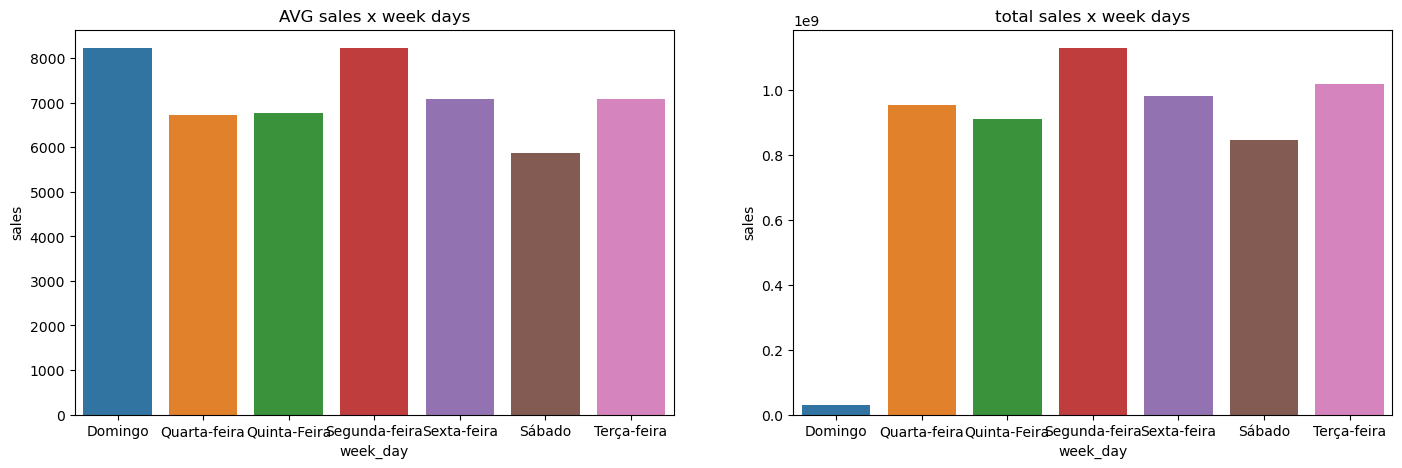

In [48]:
plt.rcParams["figure.figsize"] = (17,5)
plt.subplot(1, 2, 1)
plt.title('AVG sales x week days')
sales_weekends = df5[['date','sales']]
sales_weekends['week_day'] = sales_weekends['date'].apply(lambda x: x.weekday())
dias = ['Segunda-feira','Terça-feira','Quarta-feira','Quinta-Feira','Sexta-feira','Sábado','Domingo']
sales_weekends['week_day'] = sales_weekends['week_day'].apply(lambda x: dias[x])
sales_weekends = sales_weekends.groupby('week_day').mean().reset_index()
sns.barplot(x = 'week_day', y = 'sales', data = sales_weekends)

plt.subplot(1, 2, 2)
plt.title('total sales x week days')
sales_weekends = df5[['date','sales']]
sales_weekends['week_day'] = sales_weekends['date'].apply(lambda x: x.weekday())
dias = ['Segunda-feira','Terça-feira','Quarta-feira','Quinta-Feira','Sexta-feira','Sábado','Domingo']
sales_weekends['week_day'] = sales_weekends['week_day'].apply(lambda x: dias[x])
sales_weekends = sales_weekends.groupby('week_day').sum().reset_index()
sns.barplot(x = 'week_day', y = 'sales', data = sales_weekends)

**Hipótese 12:**  Lojas deveriam vender menos durante feriados escolares\
**FALSA** As lojas vendem mais nos feriados escolares

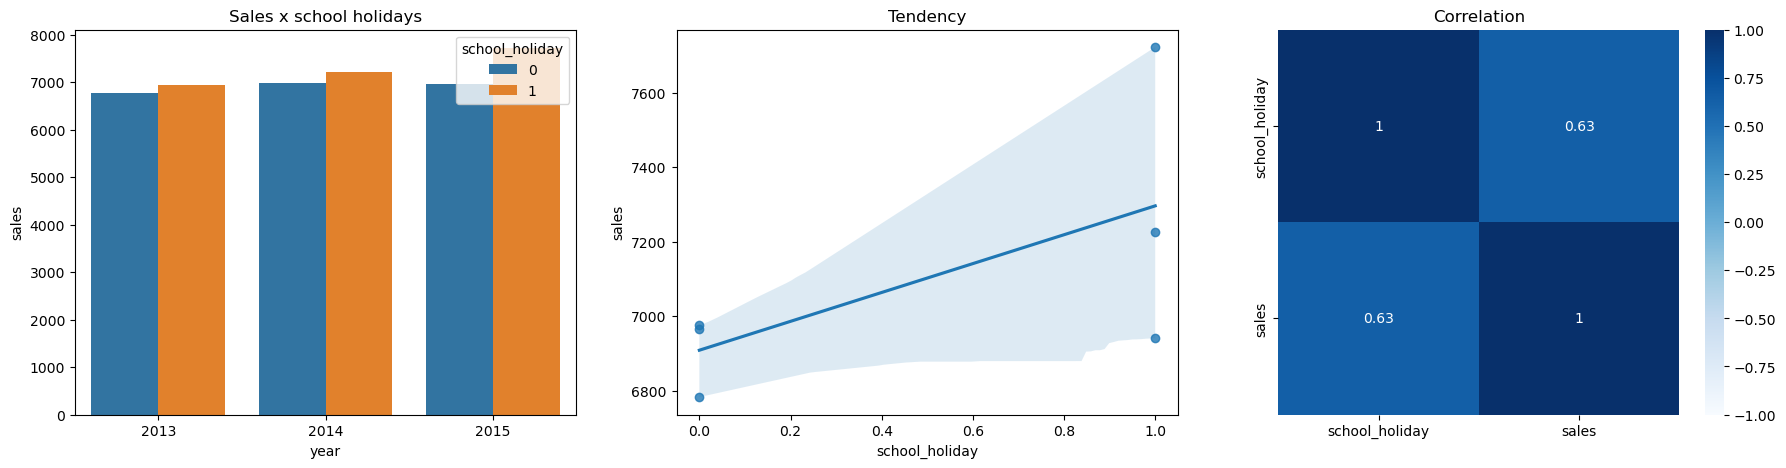

In [49]:
plt.rcParams["figure.figsize"] = (22,5)
plt.subplot(1, 3, 1)
plt.title('Sales x school holidays')
school_holiday = df5[['sales', 'year', 'school_holiday']].groupby(['school_holiday','year']).mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'school_holiday', data = school_holiday)
plt.subplot(1, 3, 2)
plt.title('Tendency')
sns.regplot(x = 'school_holiday', y = 'sales', data = school_holiday)

plt.subplot(1, 3, 3)
plt.title('Correlation')
sns.regplot(x = 'school_holiday', y = 'sales', data = school_holiday)

sns.heatmap( school_holiday[['school_holiday','sales']].corr( method='pearson' ), annot=True,cmap = 'Blues', vmin = -1, vmax = 1  );

#### 4.2.1. Resumo das Hipóteses

In [50]:
hip_conclusion = pd.DataFrame( [ ['H1',  	    'True',     	'Alta'],
                                ['H2',  	    'False',    	'Baixa'],
                                ['H3',  	    'False',    	'Média'],
                                ['H4',  	    'False',    	'Baixa'],
                                ['H5',  	    'False',    	'Média'],
                                ['H6',  	    'False',    	'Baixa'],
                                ['H7',  	    'True',	        'Média'],
                                ['H8',  	    'True', 	    'Média'],
                                ['H9',  	    'True', 	    'Alta' ],
                                ['H10', 	    'True',      	'Alta' ],
                                ['H11', 	    'True', 	    'Alta' ],
                                ['H12', 	    'False',    	'Média']],
                                columns = ['Hipótese',	'Conclusão',	'Relevância'])
hip_conclusion


,Hipótese,Conclusão,Relevância
0,H1,True,Alta
1,H2,False,Baixa
2,H3,False,Média
3,H4,False,Baixa
4,H5,False,Média
5,H6,False,Baixa
6,H7,True,Média
7,H8,True,Média
8,H9,True,Alta
9,H10,True,Alta


### 4.3. Análise Multivariada

#### 4.3.1. Numerical Attributes

<AxesSubplot:title={'center':'Correlation Heatmap'}>

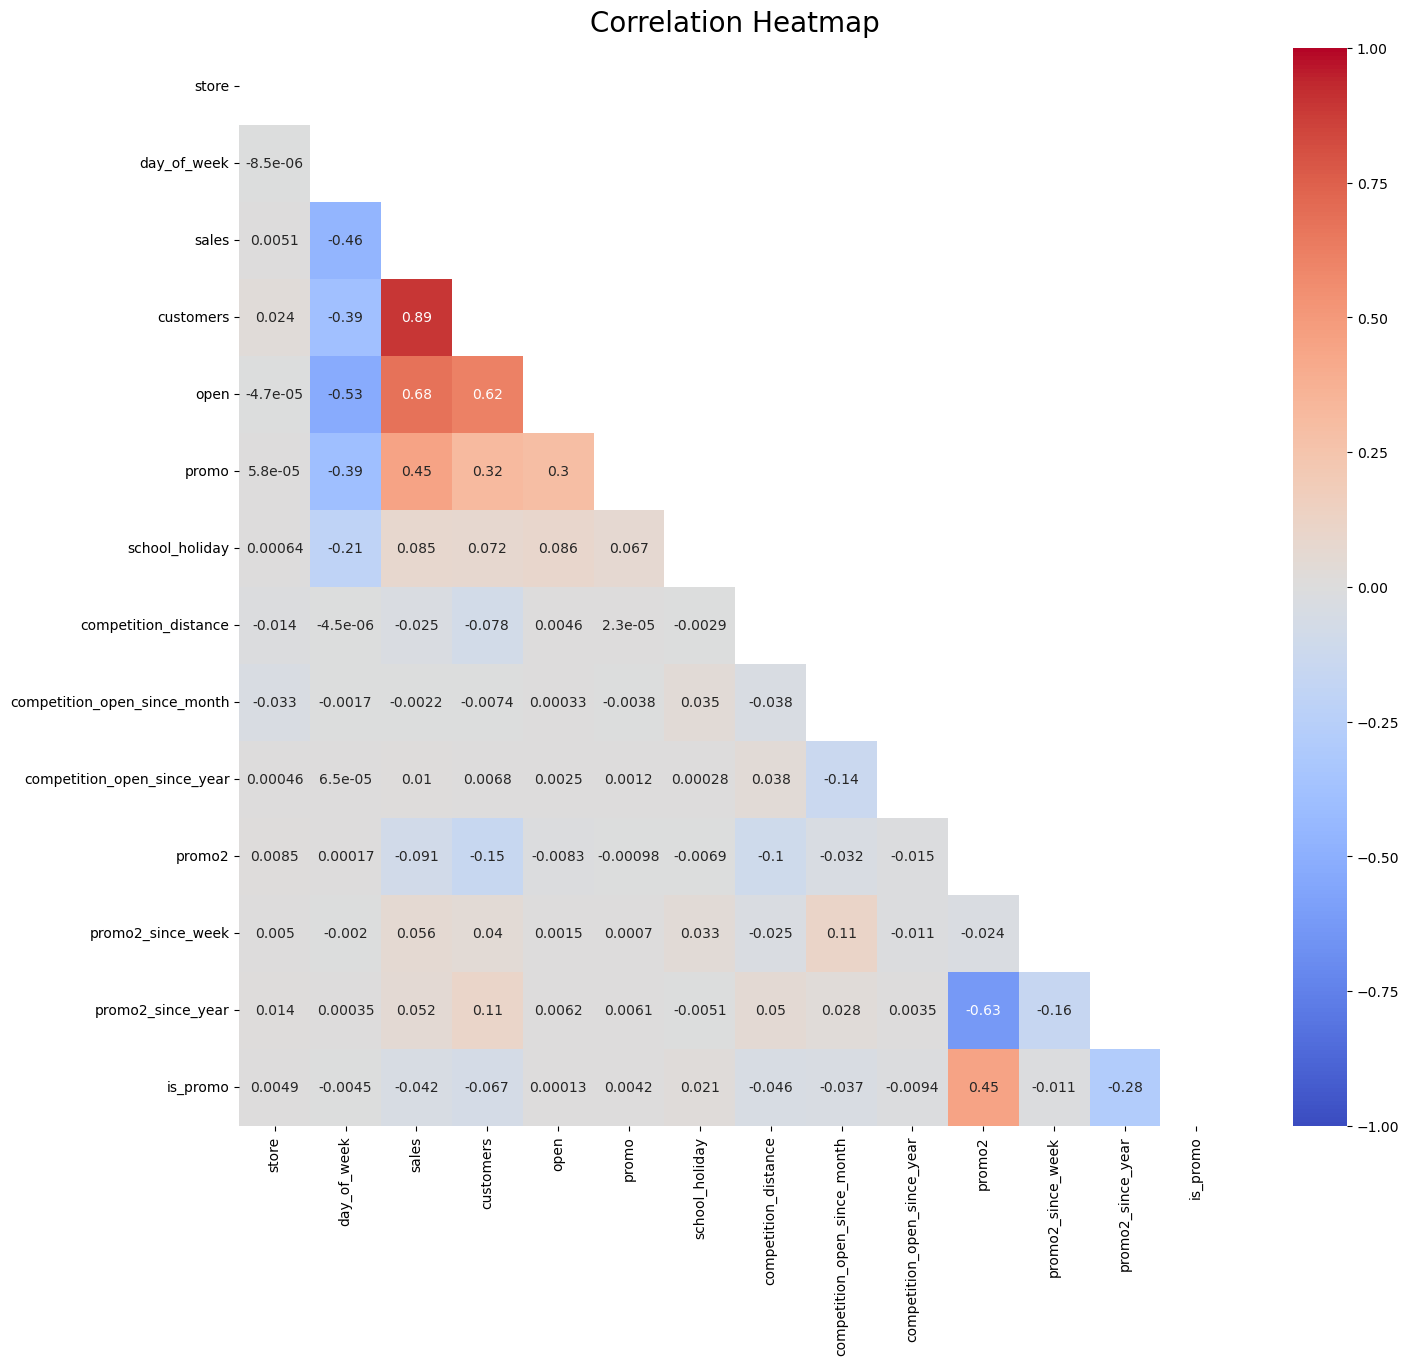

In [51]:
plt.figure(figsize=(16, 14) )
plt.title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);
correlation = num_attributes.corr(method = 'pearson')
matrix = np.triu(correlation)
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm', mask=matrix)

#### 4.3.2. Categorical Attributes

<AxesSubplot:title={'center':'Correlation Heatmap'}>

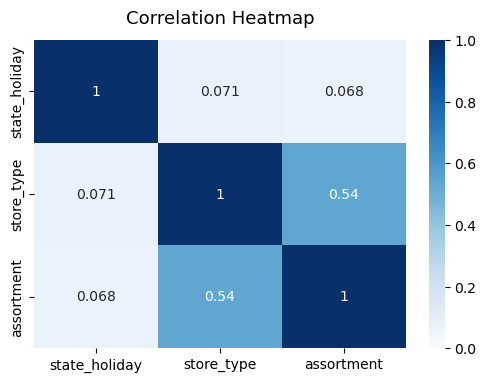

In [52]:
categorical_attributes = df5.select_dtypes( include = 'object')


# Calculate Cramer V
a1 = cramer_v(categorical_attributes['state_holiday'],categorical_attributes['state_holiday'])
a2 = cramer_v(categorical_attributes['state_holiday'],categorical_attributes['store_type'])
a3 = cramer_v(categorical_attributes['state_holiday'],categorical_attributes['assortment'])

a4 = cramer_v(categorical_attributes['store_type'],categorical_attributes['state_holiday'])
a5 = cramer_v(categorical_attributes['store_type'],categorical_attributes['store_type'])
a6 = cramer_v(categorical_attributes['store_type'],categorical_attributes['assortment'])

a7 = cramer_v(categorical_attributes['assortment'],categorical_attributes['state_holiday'])
a8 = cramer_v(categorical_attributes['assortment'],categorical_attributes['store_type'])
a9 = cramer_v(categorical_attributes['assortment'],categorical_attributes['assortment'])

# Categorical correlation dataset
cat_corr = pd.DataFrame( {'state_holiday' : [a1, a2, a3],
                          'store_type' : [a4, a5, a6], 
                          'assortment' : [a7, a8, a9]}  )
cat_corr = cat_corr.set_index(cat_corr.columns)

plt.figure(figsize=(6, 4) )
plt.title('Correlation Heatmap', fontdict={'fontsize':13}, pad=12);
sns.heatmap(cat_corr, vmin=0, vmax=1, annot=True, cmap='Blues')

In [53]:
cat_corr

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


# 5.0. Data Preparation

In [54]:
df6 = df5.copy()
numerical = df6.select_dtypes(include = ['int32', 'int64', 'float64'])
categorical = df6.select_dtypes(exclude = ['int32', 'int64', 'float64'])

In [55]:
# Cyclical
#'month'
#'day'
#'week_of_year'
#'day_of_week'

# Non cyclical
#'competition_distance'
#'year'
#'competition_time_month'
#'promo_time_week'

# Categorical
#state_holiday'
#'store_type'
#'assortment'

### 5.1. Normalization

Nothing to normalize (no normal distribution)

### 5.2. Rescaling

In [56]:
rs = RobustScaler()
#competition_distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
# Competition_time_mont
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)
mms = MinMaxScaler()
# Promo_time_week
df6['promo_time_week'] = mms.fit_transform(df6[['promo_time_week']].values)
# Year
df6['year'] = mms.fit_transform(df6[['year']].values)


### 5.3. Transformation

#### 5.3.1. Encoding

In [57]:
#state_holiday (one hot encoding)
df6 = pd.get_dummies(df6, prefix = ['state_holiday'], columns = ['state_holiday'])

#stote type (label encoding)
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])

#assortment
assortment_dict = {'basic':1,'extra':2,'extended':3}

#### 5.3.1. Encoding
df6['assortment'] = df6['assortment'].map(assortment_dict)

#### 5.3.2. Response Variable Transformation

In [58]:
# Logarithm transformation
df6['sales'] = np.log1p(df6['sales'])

#### 5.3.3. Nature transformation

In [59]:
# day_of_week
df6['day_of_week_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 )))
df6['day_of_week_cos'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 7 )))

# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 12 )))
df6['month_cos'] = df6['month'].apply(lambda x: np.sin( x * ( 2. * np.pi / 12 )))

# day 
df6['day_sin'] = df6['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30 )))
df6['day_cos'] = df6['day'].apply(lambda x: np.sin( x * ( 2. * np.pi / 30 )))

# week of year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi / 52 )))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi / 52 )))

# 6.0. Feature Selection

In [60]:
df7 = df6.copy()

In [61]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df7 = df7.drop(cols_drop, axis = 1)

### 6.1. Split dataframe into training and test

In [62]:
# Test data: 6 last weeks
df7[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [71]:
#Train dataset
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales'].values.ravel()

#Test dataset
X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']
X_test = X_test.drop(['date','sales'], axis = 1)

### 6.2. Boruta as Feature Selector

In [64]:
# Train and test datasets for Boruta
#X_train_n = X_train.drop(['date','sales'], axis = 1).values
#y_train_n = X_train['sales'].values.ravel()

#rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit(X_train_n, y_train_n)

In [65]:
#selected_cols = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#selected_cols_boruta = X_train_fs.iloc[:,selected_cols].columns

# not selected Boruta
#not_selected_cols_boruta = list(np.setdiff1d(X_train_fs.columns, selected_cols_boruta))

In [68]:
# Selecting Features according to Boruta and Hypotesis conclusions (section 4.2)
final_features = ['day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'week_of_year_cos', 'week_of_year_sin', 
                  'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_sin']

# 7.0. Machine Learning Modelling

In [72]:
df8 = df7.copy()
X_train = X_train[final_features]
X_test = X_test[final_features]

In [73]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

### 7.1. Average Model

In [76]:
X_test_avg = X_test.copy()
X_test_avg['sales'] = y_test.copy()

# Prediction
predictions = X_test_avg[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
predictions = pd.merge(X_test_avg, predictions, how = 'left', on = 'store')
yhat_baseline = predictions['predictions']

#Performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 7.2. Linear Regression Model

In [80]:
# model
lr = LinearRegression().fit(X_train, y_train)

# Prediction
yhat_lr = lr.predict(X_test)

# Performance
lr_result = ml_error('Linear Regression',  np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1886.845859,0.296328,2694.659958


### 7.3. Linear Regression Regularized Model - Lasso

In [81]:
# model
lasso = Lasso(alpha = 0.0001).fit(X_train, y_train)

# Prediction
yhat_lasso = lasso.predict(X_test)

# Performance
lasso_result = ml_error('Linear Regression - Lasso',  np.expm1(y_test), np.expm1(yhat_lasso))
lasso_result

KeyboardInterrupt: 